In [16]:
library(tidyverse)
library(igraph)

In [17]:
# edges = read.csv('../datasets/wits/simulated/edgelist.csv')
# nodes = read.csv('../datasets/wits/simulated/nodelist.csv')
# edges = read.csv('../datasets/wits/edgelist_2011.csv')
# nodes = read.csv('../datasets/wits/nodelist_2011.csv')
nodes = read.csv('../datasets/wits/nl_no_missing.csv')
edges = read.csv('../datasets/wits/el_no_missing.csv')

In [18]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,NPL,LBR,97.061
2,NPL,AZE,46.502
3,NPL,JOR,25.551


In [19]:
n = dim(nodes)[1]
N = 1000
country_names = nodes$country_iso3
nodes = transform(nodes, landlocked=as.logical(landlocked))

In [20]:
trade_graph = igraph::graph_from_edgelist(as.matrix(edges[, c("source", "target")]), directed = F) %>%
    igraph::set_edge_attr(name = "weight", value = edges$weight)

In [21]:
louvain_partitions = igraph::cluster_louvain(graph = trade_graph)

In [22]:
trade_graph$community = louvain_partitions$membership

In [23]:
communities_summary = data.frame()
for (i in unique(louvain_partitions$membership)) {
    subgraph = induced_subgraph(graph = trade_graph, vids = which(trade_graph$community == i))
    
    size = igraph::gorder(graph = subgraph)
    
    btwn_cent = betweenness(graph = subgraph)
    
    central_node = names(which(btwn_cent == max(btwn_cent)))
    
    communities_summary = communities_summary %>%
        dplyr::bind_rows(
            data.frame(
                community = i, 
                size = size, 
                central_node = central_node
            )
        )
    
}

In [24]:
communities_summary

community,size,central_node
<dbl>,<int>,<chr>
3,63,MDG
1,55,NER
2,23,SUR


In [25]:
numerical_columns = names(which(unlist(lapply(nodes, is.numeric))))

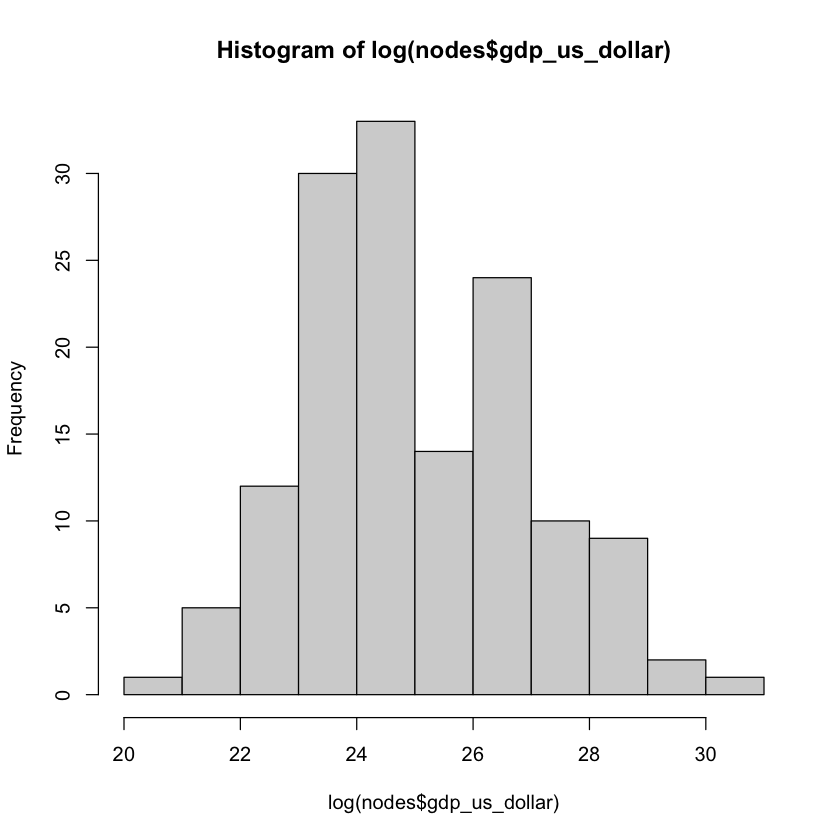

In [26]:
par(bg = 'white')
hist(log(nodes$gdp_us_dollar))

In [28]:
values = log(nodes[, 'gdp_us_dollar'])
breaks = c(quantile(values)[1] - 1, quantile(values)[2], quantile(values)[4], quantile(values)[5] + 1)
tags = c('Low', 'Medium', 'High')
nodes$gdp_us_dollar = cut(values, breaks = breaks, labels = tags)

In [29]:
head(nodes, 3)

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,colonizer,area,landlocked,continent,langoff_1,population,gdp_per_capita,life_expectancy,gni_atlas,agriculture_forestry_fishing_of_gdp,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows,happiness
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,Medium,11.804186,0.4263548,USA,652225,TRUE,Asia,Persian,30117411,591.1628,61.553,16077121256,23.743664,22.74025,38.70415,144.7519,52173421,0.721
2,AGO,Medium,13.482468,3.4719763,PRT,1246700,FALSE,Africa,Portuguese,24220660,4615.4682,56.330,82606027251,5.845681,56.02651,78.30597,244.3292,-3023770966,0.708
3,ALB,Low,3.429123,2.5453218,NONE,28748,FALSE,Europe,Albanian,2905195,4437.1429,76.914,12803715190,18.226765,24.48441,56.86241,94.3372,1048706682,0.568


In [30]:
communities_df = data.frame(
    country = louvain_partitions$names, 
    community = louvain_partitions$membership
)

In [31]:
nodes = merge(x = nodes, y = communities_df, by.x = 'country_iso3', by.y = 'country')

In [32]:
num_communities = length(unique(nodes$community))

In [33]:
get_between_within_counts = function(nodes, edges, permutate=F) {
    if (permutate == T) {
        nodes$gdp_us_dollar = sample(nodes$gdp_us_dollar, size = n, replace = F)
    }
    levels = c('Low', 'Medium', 'High')
    btwn_wthn_trade_counts = data.frame()
    for (i in 1:num_communities) {
        for (j in 1:num_communities) {
            for (source_level in levels) {
                for (target_level in levels) {
                    btwn_wthn_trade_counts = btwn_wthn_trade_counts %>%
                        dplyr::bind_rows(
                            data.frame(
                                source_community = i, 
                                target_community = j, 
                                source_gdp_level = source_level, 
                                target_gdp_level = target_level,
                                edge_count = count(
                                    edges %>% 
                                        dplyr::filter(
                                            source %in% nodes$country_iso3[which(nodes$community == i)] & 
                                            target %in% nodes$country_iso3[which(nodes$community == j)] & 
                                            source %in% nodes$country_iso3[which(nodes$gdp_us_dollar == source_level)] &
                                            target %in% nodes$country_iso3[which(nodes$gdp_us_dollar == target_level)]
                                        )
                                )
                            )
                        )
                }
            }
        }
    }
    return(btwn_wthn_trade_counts)
}

In [34]:
execute_chisq_test = function(btwn_wthn_trade_counts) {
    reshaped_btwn_wthn_trade_counts = matrix(data = btwn_wthn_trade_counts$n, nrow = 9, ncol = 9)
    rownames(reshaped_btwn_wthn_trade_counts) = paste(c(rep('Low', 3), rep('Medium', 3), rep('High', 3)), rep(c('Low', 'Medium', 'High'), 3))
    colnames(reshaped_btwn_wthn_trade_counts) = paste(c(rep(1, 3), rep(2, 3), rep(3, 3)), rep(1:3, 3))
    chisq.result = chisq.test(reshaped_btwn_wthn_trade_counts)
    return(reshaperesult)
}

In [35]:
btwn_wthn_trade_counts_observed = get_between_within_counts(nodes, edges)

In [36]:
head(btwn_wthn_trade_counts_observed, 3)

,source_community,target_community,source_gdp_level,target_gdp_level,n
,<int>,<int>,<chr>,<chr>,<int>
1,1,1,Low,Low,41
2,1,1,Low,Medium,196
3,1,1,Low,High,140


In [37]:
chisq.result.observed = execute_chisq_test(btwn_wthn_trade_counts_observed)
chisq.result.observed.statistic = chisq.result.observed$statistic

In [38]:
chisq.result.observed.statistic

X-squared 
 1041.977

In [39]:
permutated_chisq_statistics = matrix(0, nrow = N)
for (i in 1:N) {
    btwn_wthn_trade_counts_permutated = get_between_within_counts(nodes, edges, permutate = T)
    permutated_chisq_statistics[i] = execute_chisq_test(btwn_wthn_trade_counts_permutated)$statistic
}

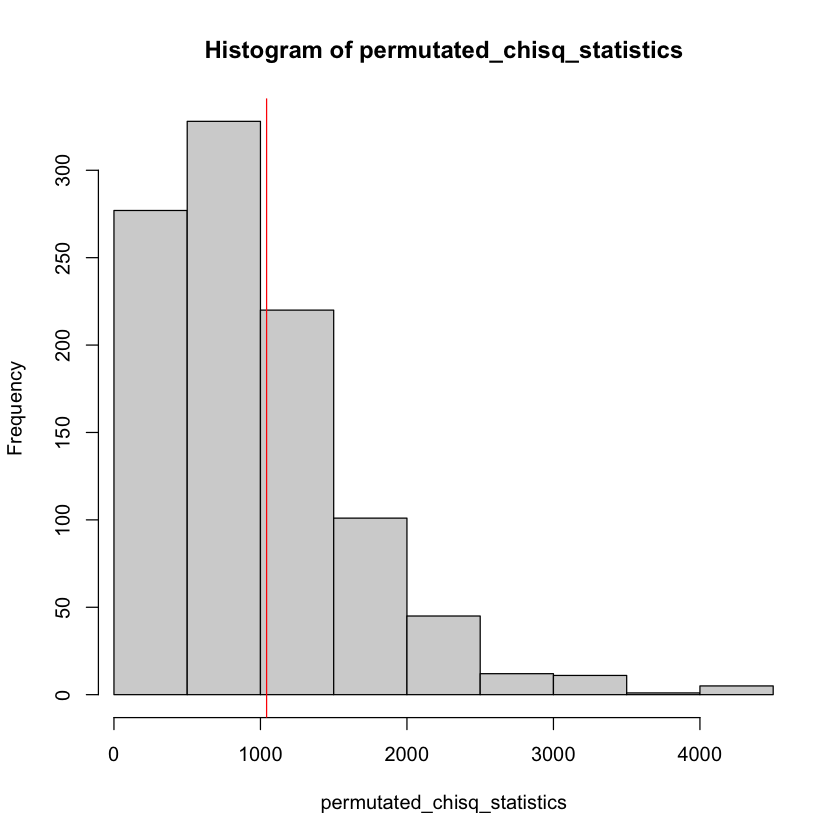

In [40]:
par(bg = 'white')
hist(
    permutated_chisq_statistics, 
    xlim = c(
        min(min(permutated_chisq_statistics), chisq.result.observed.statistic), 
        max(max(permutated_chisq_statistics), chisq.result.observed.statistic)
    )
)
abline(v = chisq.result.observed.statistic, col = 'red')

In [46]:
library(MASS)

In [47]:
chisq.result.observed.statistic

X-squared 
 1041.977

In [48]:
write.matrix(permutated_chisq_statistics, './permutated_chisq_statistics.txt', sep = '\n')